# Performing LR with Mini-Batch Gradient Descent

This notebook implements **mini-batch gradient descent** for a simple **linear regression** model:

$$
\hat{y} = XW + b
$$

I implement:
- a single gradient step for **mean squared error (MSE)**
- run mini-batch GD
- visualize **fit evolution**, **loss curves**, and the **loss surface** in \((W, b)\) space

> If `data.csv` isn’t present, the notebook generates a small synthetic dataset so everything runs without


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Setting a random seed
np.random.seed(42)

## Load (or generate) data

Expected CSV format: each row is `x, y` (or multiple features ending with `y`).

If `data.csv` is missing, we generate a simple noisy line:
\[
y = 3x + 2 + \epsilon
\]


In [3]:
# Load data from CSV if present; otherwise generate a toy dataset
csv_path = "data.csv"

if os.path.exists(csv_path):
    data = np.loadtxt(csv_path, delimiter=",")
else:
    n = 120
    x = np.random.uniform(-3, 3, size=n)
    noise = np.random.normal(0, 1.0, size=n)
    y = 3.0 * x + 2.0 + noise
    data = np.column_stack([x, y])
    np.savetxt(csv_path, data, delimiter=",")

X = data[:, :-1]
y = data[:, -1]

# Ensure X is 2D (n, d)
if X.ndim == 1:
    X = X.reshape(-1, 1)

print(f"Loaded X shape: {X.shape}, y shape: {y.shape}  (from {csv_path})")

Loaded X shape: (120, 1), y shape: (120,)  (from data.csv)


## 1) Implement one MSE gradient step

We minimize the **mean** squared error:

$$
\text{MSE}(W,b)=\frac{1}{n}\sum_{i=1}^{n}\left(y_i-(X_i W+b)\right)^2
$$

Gradients:

$$
\nabla_W = -\frac{2}{n}X^\top (y-\hat{y}),
\qquad
\nabla_b = -\frac{2}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)
$$

Update:

$$
W \leftarrow W - \alpha \nabla_W,
\qquad
b \leftarrow b - \alpha \nabla_b
$$


In [4]:
def mse(X, y, W, b):
    """Mean squared error for a linear model."""
    y_pred = X @ W + b
    return np.mean((y - y_pred) ** 2)


def MSEStep(X, y, W, b, learn_rate=0.005):
    """
    Perform one gradient descent step for MSE loss.

    Parameters
    ----------
    X : (n, d) array
        Predictor features.
    y : (n,) array
        Target values.
    W : (d,) array
        Current weights.
    b : float
        Current intercept.
    learn_rate : float
        Learning rate (alpha).

    Returns
    -------
    W_new : (d,) array
        Updated weights.
    b_new : float
        Updated intercept.
    """
    n = X.shape[0]

    # Predictions and error
    y_pred = X @ W + b
    error = y - y_pred  # (n,)

    # Gradients (for mean squared error)
    dW = (-2.0 / n) * (X.T @ error)          # (d,)
    db = (-2.0 / n) * np.sum(error)          # scalar

    # Update step
    W_new = W - learn_rate * dW
    b_new = b - learn_rate * db

    return W_new, b_new

## 2) Mini-batch gradient descent loop

We repeatedly:
1. sample a batch of points,
2. take one gradient step using that batch,
3. track full-dataset MSE for a clean learning curve.


In [5]:
def miniBatchGD(X, y, batch_size=20, learn_rate=0.005, num_iter=25):
    """
    Mini-batch gradient descent for linear regression.

    Returns a history dict containing:
      - W: list of weight vectors
      - b: list of intercepts
      - mse: full-dataset MSE after each update
      - batch_idx: indices used for each mini-batch
    """
    n_points, n_features = X.shape
    W = np.zeros(n_features)
    b = 0.0

    history = {
        "W": [W.copy()],
        "b": [b],
        "mse": [mse(X, y, W, b)],
        "batch_idx": []
    }

    for _ in range(num_iter):
        # Sample indices for the mini-batch
        replace = batch_size > n_points
        batch = np.random.choice(n_points, size=batch_size, replace=replace)
        X_batch = X[batch, :]
        y_batch = y[batch]

        # One gradient step on the batch
        W, b = MSEStep(X_batch, y_batch, W, b, learn_rate)

        # Track full-dataset performance
        history["W"].append(W.copy())
        history["b"].append(b)
        history["mse"].append(mse(X, y, W, b))
        history["batch_idx"].append(batch)

    return history

## 3) Run training + visuals

In [6]:
# Hyperparameters (tweak these!)
batch_size = 20
learn_rate = 0.02
num_iter = 60

hist = miniBatchGD(X, y, batch_size=batch_size, learn_rate=learn_rate, num_iter=num_iter)

W_hist = np.array(hist["W"])          # (num_iter+1, d)
b_hist = np.array(hist["b"])          # (num_iter+1,)
mse_hist = np.array(hist["mse"])      # (num_iter+1,)

print("Final parameters:")
print("W =", W_hist[-1])
print("b =", b_hist[-1])
print("Final MSE =", mse_hist[-1])

Final parameters:
W = [2.99097773]
b = 1.847000784684116
Final MSE = 1.0063177620334354


### Visual A — Data + regression lines over time

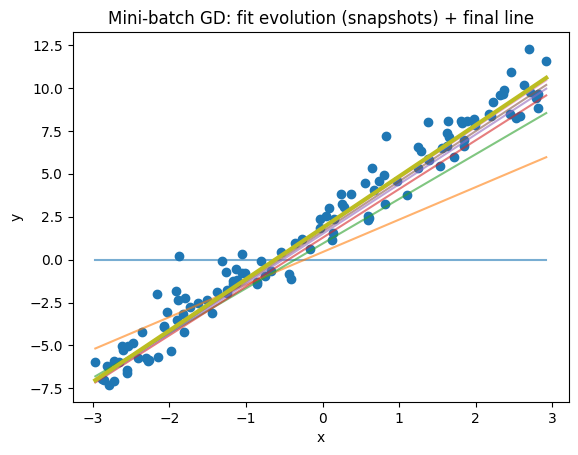

In [7]:
# For visualization, this section assumes 1 feature (d=1).
# If you have multiple features, we'll plot y vs the first feature.
x1 = X[:, 0]
x_min, x_max = x1.min(), x1.max()

plt.figure()
plt.scatter(x1, y)

# Plot a few snapshots (early, mid, late) to show progression
snapshots = np.linspace(0, len(b_hist) - 1, 8, dtype=int)
for i in snapshots:
    W_i = W_hist[i][0]
    b_i = b_hist[i]
    xs = np.array([x_min, x_max])
    ys = xs * W_i + b_i
    plt.plot(xs, ys, alpha=0.6)

# Plot final fit on top
W_f = W_hist[-1][0]
b_f = b_hist[-1]
plt.plot([x_min, x_max], [x_min * W_f + b_f, x_max * W_f + b_f], linewidth=3)

plt.title("Mini-batch GD: fit evolution (snapshots) + final line")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Visual B — Learning curve (MSE vs iteration)

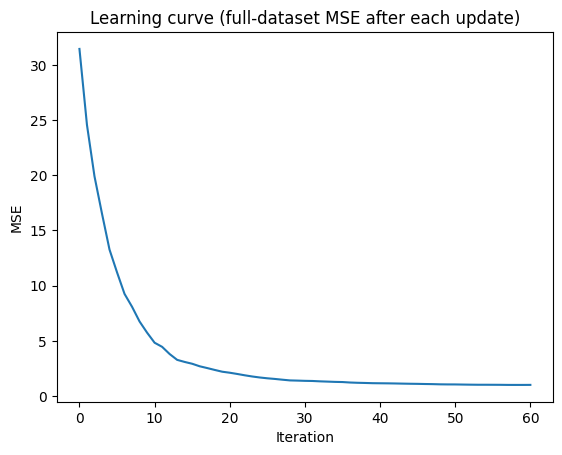

In [8]:
plt.figure()
plt.plot(mse_hist)
plt.title("Learning curve (full-dataset MSE after each update)")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()

### Visual C — Parameter trajectory (W and b over time)

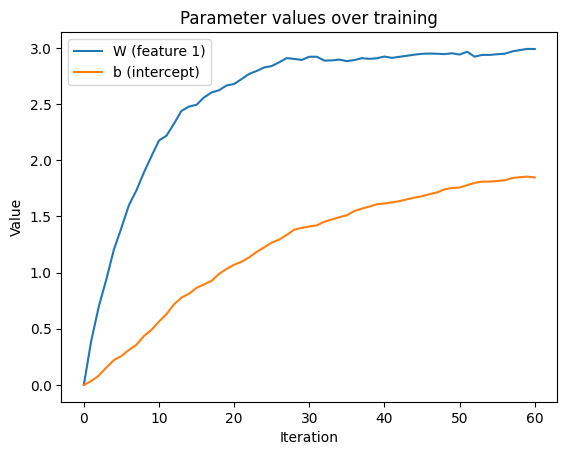

In [9]:
plt.figure()
plt.plot(W_hist[:, 0], label="W (feature 1)")
plt.plot(b_hist, label="b (intercept)")
plt.title("Parameter values over training")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()
plt.show()

### Visual D — Loss surface in (W, b) space + GD path

For 1D linear regression, the loss is a smooth bowl in \((W, b)\) space.
We’ll plot MSE contours and overlay the parameter path.


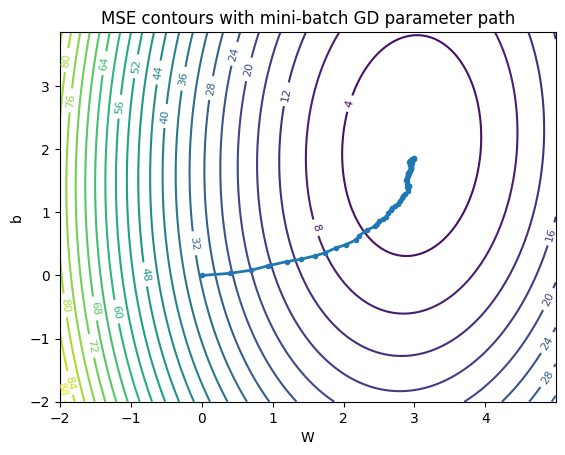

In [10]:
# Build a grid over (W, b) and compute MSE for contours (1 feature)
W_vals = np.linspace(W_hist[:, 0].min() - 2, W_hist[:, 0].max() + 2, 120)
b_vals = np.linspace(b_hist.min() - 2, b_hist.max() + 2, 120)

WW, BB = np.meshgrid(W_vals, b_vals)
Z = np.zeros_like(WW)

for i in range(WW.shape[0]):
    # Vectorized over W for each row is possible, but this is simple + clear for small grids
    for j in range(WW.shape[1]):
        Z[i, j] = mse(X, y, np.array([WW[i, j]]), BB[i, j])

plt.figure()
cs = plt.contour(WW, BB, Z, levels=25)
plt.clabel(cs, inline=True, fontsize=8)

# Path of (W, b)
plt.plot(W_hist[:, 0], b_hist, marker="o", markersize=3, linewidth=2)

plt.title("MSE contours with mini-batch GD parameter path")
plt.xlabel("W")
plt.ylabel("b")
plt.show()

Think of this plot like a **topographic map**, but instead of showing “height,” it shows **how wrong the model is** (its **loss / MSE**).

### What the axes mean:
- **W (x-axis)** = the **slope** of your line  
- **b (y-axis)** = the **intercept** of your line  

Every point **(W, b)** represents a different line.

### Visual E — Compare batch sizes

Smaller batches add noise (more jitter), but can move fast.
Full-batch tends to be smooth but can be slower per step.


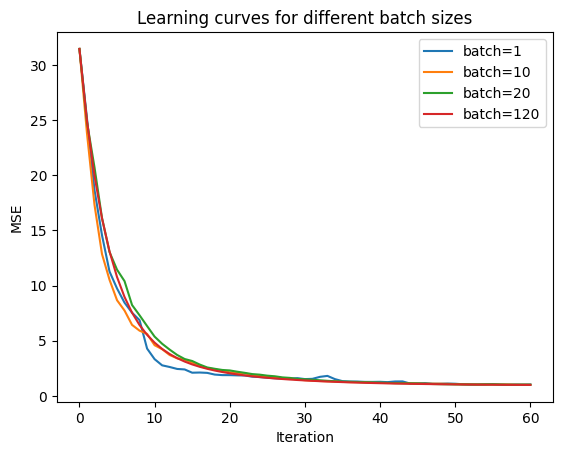

In [11]:
def run_and_get_mse(batch_size, learn_rate=0.02, num_iter=60):
    h = miniBatchGD(X, y, batch_size=batch_size, learn_rate=learn_rate, num_iter=num_iter)
    return np.array(h["mse"])

n_points = X.shape[0]
batch_sizes = [1, 10, 20, n_points]

plt.figure()
for bs in batch_sizes:
    curve = run_and_get_mse(bs, learn_rate=learn_rate, num_iter=num_iter)
    plt.plot(curve, label=f"batch={bs}")
plt.title("Learning curves for different batch sizes")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()